## [**Harvard DataFest 2020**](https://harvarddatafest2020.sched.com/event/YNuw/data-intensive-non-linear-dimensionality-reduction-and-visualization-t-sne-pca-using-notebooks-on-cluster-gpu-cpu-implementations?iframe=yes&w=100%&sidebar=yes&bg=no)

**Session Topic**: Data Intensive (Non)-Linear Dimensionality Reduction and Visualization (t-SNE & PCA) Using Notebooks on Cluster: GPU & CPU Implementations

**Date/Time**: Wednesday, January 22 , 3:00pm - 4:45pm

**Speaker**: Mahmood M. Shad (Manager of Research Software Engineering, FAS Research Computing)

## Outline

#### 1. Import Python modules and define general functions  
#### 2. Datasets  
#### 3. Introduction to PCA   
#### 4. PCA on small and large dataset: CPU  
#### 5. PCA on small and large dataset: GPU  
#### 6. Introduction to t-SNE   
#### 7. t-SNE on small and large dataset: CPU  
#### 8. t-SNE on small and large dataset: GPU  

## 1. Import Python modules and define general functions

In [1]:
# Import Python Modules

# Timing
import time

# Plot
import matplotlib.pyplot as plt

# Read data
import h5py
import numpy as np

# PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from cuml import PCA as cumlPCA
from cuml.decomposition import PCA as cumlPCA


# t-SNE
from sklearn.manifold import TSNE
from MulticoreTSNE import MulticoreTSNE as mlcoreTSNE
from cuml.manifold import TSNE as cumlTSNE

In [29]:
class Timer(object):
    """
    Time code snippets
    """
    
    def __init__(self, name=None):
        self.name = name

    def __enter__(self):
        self.tstart = time.time()

    def __exit__(self, type, value, traceback):
        if self.name:
            print('[%s]' % self.name,)
        print('Elapsed: %s' % (time.time() - self.tstart) + '\n')

        
def plot_pca(prc1, prc2, title_ex=""):
    """
    Plot PCA
    """
    
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.scatter(prc1, prc2, s=2, c="blue", alpha=0.2, marker="o", label='PCA')
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')  
    plt.title('Principal Components Plot' + ": " + title_ex)
    plt.legend(loc='upper right');
    plt.show()
    
    
def load_hdf5(f_name):
    """
    Load HDF5 dataset
    """
    
    with h5py.File(f_name, 'r') as f:
        a_group_key = list(f.keys())[0]
        data = np.array(f[a_group_key]).T
    return data


def plot_tsne(c1, c2, title_ex=""):
    """
    Plot t_SNE 
    """
    
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.scatter(c1, c2, s=2, c="blue", alpha=0.1, marker="o", label='t_SNE')
    plt.xlabel('t_SNE Component 1')
    plt.ylabel('t_SNE Component 2')  
    plt.title('t_SNE Components Plot' + ": " + title_ex)
    plt.legend(loc='upper right');
    plt.show()

## 2. Datasets

Download datasets: [Dropbox Link](https://www.dropbox.com/sh/jnqak5qhxol0zig/AABizfe1vaCbqSF1FjJmWZNya?dl=0)

You can check the structure of an HDF5 file in [HDF View Software](https://www.hdfgroup.org/downloads/hdfview/). The software is available for free by [The HDF Group](https://www.hdfgroup.org/downloads/hdfview/).


**Advantage of HDF5 format**:
- Hierarchical structure (same as folders/files)
- Optional metadata for each item
- Flexibly sized. No need to re-write the whole data
- Optional chunked HDF5 dataset (faster read): large matrices
- Self-contained data store (rather than a database)
- Widely supported (despite npy/npz numpy files): Python, R, C, Java, and Perl

In [26]:
# Get smaller dataset
small_data = load_hdf5('small_dataset.h5')

# Get larger dataset
large_data = load_hdf5('large_dataset.h5')

## 3. Introduction to PCA

<div style="text-align:center"><img src=https://devopedia.org/images/article/139/4543.1548137789.jpg width="600" title="Source: Lavrenko and Sutton 2011, Slide 13" align="center"></div>

**Goal**: Extract most important information. It means compression?

<div style="text-align:center"> Less Memory and Faster Computation   [---- TRADE-OFF ----]    Information Loss</div>

.

**Most Common Application of PCA**: If the input dimension is too high.

**What is PCA**? PCA reduces the dimensionality of the dataset while keeping the maximum possible variation present in the dataset.

**Example**: 

<div style="text-align:center"><img src=https://devopedia.org/images/article/139/9153.1547301619.png width="600" title="Source: Werner and Friedrich 2014" align="center"></div>

- Transform  `hight` and `width` variables to two orthogonal variables.
- The blue line (first component) explains most of the variation in the data.
- The second component explains the remaining variation. 
- Both orthogonal components are linear combination of `hight` and `width`

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  $PC_1 = \alpha_1 \times hight + \beta_1 \times width$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  $PC_2 = \alpha_2 \times hight + \beta_2 \times width$


**Is PCA same as dimensionality reduction?**: Feature Elimination vs. Feature Extraction (PCA)

**PCA Advantages**:
- Minimization of information loss  
- Unsupervised learning method and no need for *a priori* on components!  
- Easier data visualization: **patterns**, **clusters**, and **trends**  
- Noice reduction  
- Just an eigenvalue/eigenvector problem  
- Maximizes variance and preserves large pairwise distances  


**PCA Drawbacks**:
- Only **linearly** correlated variables   
- Fails when no correlation  
- Information loss  
- Different results if **scaling**
- No meaningful visualization to relate original variables   

## 4. PCA on small and large dataset: CPU

In [27]:
# Scaling data: mean = 0 & variance = 1
small_data = StandardScaler().fit_transform(small_data)
large_data = StandardScaler().fit_transform(large_data)

In [5]:
# PCA transform: CPU Serial
pca_1 = PCA(n_components=2)
pca_2 = PCA(n_components=2)

with Timer("PCA_Small_Dataset"):
    pr_comps_1 = pca_1.fit_transform(small_data)

with Timer("PCA_Large_Dataset"):
    pr_comps_2 = pca_2.fit_transform(large_data)

[PCA_Small_Dataset]
Elapsed: 0.1738286018371582

[PCA_Large_Dataset]
Elapsed: 5.065084934234619



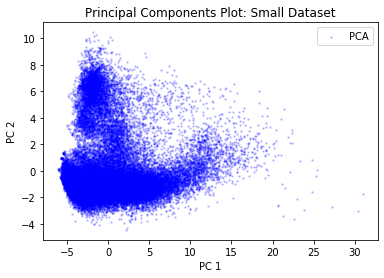

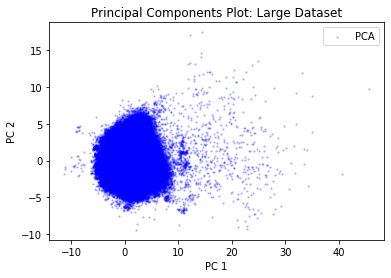

In [6]:
# Plot PCA
plot_pca(pr_comps_1[:,0], pr_comps_1[:,1], "Small Dataset")
plot_pca(pr_comps_2[:,0], pr_comps_2[:,1], "Large Dataset")

In [7]:
# Explained variance by PCA
print('Explained variance by PCA: small dataset:')
print(pca_1.explained_variance_ratio_*100)

print('Explained variance by PCA: large dataset:')
print(pca_2.explained_variance_ratio_*100)

Explained variance by PCA: small dataset:
[21.79083916  6.99218158]
Explained variance by PCA: large dataset:
[6.82614732 5.17513298]


**What do you think about PCA results?**

**Why explained variance by PCA is not high enough on both datasets?**

**Is there any sign of nonlinear relation between variables in the dataset?**

**Time complexity of PCA ($n$ observations, $d$ dimensions)**

- Covariance matrix computation: $O(d^2n)$
- Eigen-value decomposition: $O(d^3)$.
- PCA: $O(d^2n+d^3)$.

## 5. PCA on small and large dataset: GPU

In [8]:
# Nvidia RAPIDS cuML PCA
pca_1 = cumlPCA(n_components = 2)
pca_2 = cumlPCA(n_components = 2)

with Timer("PCA_Small_Dataset"):
    pr_comps_1 = pca_1.fit_transform(small_data)

with Timer("PCA_Large_Dataset"):
    pr_comps_2 = pca_2.fit_transform(large_data)

[PCA_Small_Dataset]
Elapsed: 0.5825843811035156

[PCA_Large_Dataset]
Elapsed: 0.23993468284606934



In [9]:
# Explained variance by PCA
print('Explained variance by PCA: small dataset:')
print(pca_1.explained_variance_ratio_*100)

print('Explained variance by PCA: large dataset:')
print(pca_2.explained_variance_ratio_*100)

Explained variance by PCA: small dataset:
0    21.790839
1     6.992182
dtype: float64
Explained variance by PCA: large dataset:
0    6.826147
1    5.175135
dtype: float64


## 6. Introduction to t-SNE

<div style="text-align:center"><img src=https://www.researchgate.net/profile/Lei_Luo6/publication/258392870/figure/fig3/AS:323073124388865@1454038043128/From-a-to-d-a-Swiss-roll-and-its-hash-codes-embedded-to-3D-by-PCA-after-applying.png width="400" title="Source: L. Luo, C. Zhang, Y. Qin, C. Zhang, Mathematical Problems in Engineering 2013" align="center"></div>

**Stochastic Neighbor Embedding (SNE)**  

**SNE Goal**: Use conditional probabilities to match distributions of distances (Gaussian-distributed) between data points in high dimensional (HD) and low dimensional (LD) space.

Conditional probabilities in HD and LD space:

$p_{j|i} = \frac{\exp{(-||x_i-x_j||^2/2\sigma_i^2)}}{\sum_{k\neq i}{\exp{(-||x_i-x_k||^2/2\sigma_i^2)}}}$

$q_{j|i} = \frac{\exp{(-||y_i-y_j||^2)}}{\sum_{k\neq i}{\exp{(-||y_i-y_k||^2)}}}$

$p_{i|i} = q_{i|i} = 0$

Match these functions by minimizing the cost function (sum of [Kullback-Leibler](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) divergences),

$C = \sum_i{KL(P_i||Q_i)} = \sum_i\sum_j{p_{j|i} log(\frac{p_{j|i}}{q_{j|i}})}$


KL divergence is asymmetric,
- Nearby data points in HD space to widely separated data points in LD space: high cost
- Widely separated data points in HD space to nearby data points in LD space: low cost
- **Thus it preserves local structure.**
- The $\sigma_i$ is called **perplexity** ~ number of close neighbors of each data points
- Gradient of the cost function in SNE:   
$\frac{\partial C}{\partial y_i} = 2 \sum_j{( p_{j|i} - q_{j|i} + p_{i|j} - q_{i|j} ) ( y_i - y_j )}$

- SNE utilizes Gradient Descent for optimization.
- SNE addes a momentum term: speed up the optimization, avoid local optima   
$y^{(t)} = y^{(t-1)} + \eta \frac{\partial C}{\partial y} + \alpha(t) (y^{(t-1)} - y^{(t-2)})$
- Issues with SNE: difficulty in **optimization of cost function** and **crowding problem**

**How to resolve issues in SNE**?
Symmetric SNE has a symmetric cost function ($p_{i|j}=p_{j|i}$ and $q_{i|j}=q_{j|i}$).

In symmetric SNE, we have $p_{ij}=p_{ji}$ and $p_{ii}=q_{ii}=0$,

$p_{ij} = \frac{\exp{(-||x_i-x_j||^2/2\sigma^2)}}{\sum_{k\neq l}{\exp{(-||x_k-x_l||^2/2\sigma^2)}}}$

$q_{ij} = \frac{\exp{(-||y_i-y_j||^2)}}{\sum_{k\neq l}{\exp{(-||y_k-y_l||^2)}}}$

Gradient of the cost function in symmetric SNE:   
$\frac{\partial C}{\partial y_i} = 4 \sum_j{( p_{ji} - q_{ji} ) ( y_i - y_j )}$


**Another solution to SNE: t-SNE**
- t-SNE: **t-Distributed Stochastic Neighbor Embedding**
- **Unsupervised** and **non-linear** dimensionality reduction technique
- Data exploration and visualizing **high-dimensional data**
- *Laurens van der Maatens* and *Geoffrey Hinton* in 2008
- Preserves only small pairwise distances or local similarities
- Preserves local structure and the global structure [as much as possible]
- PCA preserves large pairwise distances to maximize variance
- Computes data points similarities in LD space by **Student t-distribution**
- [Barnes-Hut implementation of t-SNE](https://lvdmaaten.github.io/publications/papers/JMLR_2014.pdf) makes algorithm faster by using a tree structure

In t_SNE, a student t-distribution is used to represent LD map. It is **robust to outliers** and is **faster to compute** (no exponent),

$q_{ij} = \frac{(1+||y_i-y_j||^2)^{-1}}{\sum_{k\neq l}{(1+||y_k-y_l||^2)^{-1}}}$

$\frac{\partial C}{\partial y_i} = 4 \sum_j{( p_{ji} - q_{ji} ) ( y_i - y_j ) (1+||y_i-y_j||^2)^{-1}}$


**t-SNE algorithm**

**begin**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1. Compute pairwise affinities $p_{j|i}$ with perplexity Prep  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2. Set $p_{ij} = \frac{p_{i|j}+p_{j|i}}{2n}$ ($n$: number of data points)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3. Sample initial solution $Y^{(0)} = y_1, y_2,. . .,y_n$ from $N(0, 10^{-4}/)$  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **for** $t=1$ **to** $T$ **do**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Compute low-dimensional affinities $q_{ij}$  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Compute gradient $\frac{\partial C}{\partial y}$  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Set $y^{(t)} = y^{(t-1)} + \eta \frac{\partial C}{\partial y} + \alpha(t) (y^{(t-1)} - y^{(t-2)})$  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **end**  
**end**

**[How to Use t-SNE Effectively](https://distill.pub/2016/misread-tsne/)**

Reference: [t_SNE](https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf), [t-SNE formulas](https://github.com/Divyagash)

## 7. t-SNE on small and large dataset: CPU 

In [10]:
# CPU: Serial
# t-SNE transform
tsne_1 = TSNE(n_components=2, n_jobs=-1, verbose=1)
tsne_2 = TSNE(n_components=2, n_jobs=-1, verbose=1)

with Timer("tSNE_Small_Dataset"):
    tsne_comps_1 = tsne_1.fit_transform(small_data)

# with Timer("tSNE_Large_Dataset"):
#     tsne_comps_2 = tsne_2.fit_transform(large_data)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 42892 samples in 0.336s...
[t-SNE] Computed neighbors for 42892 samples in 120.142s...
[t-SNE] Computed conditional probabilities for sample 1000 / 42892
[t-SNE] Computed conditional probabilities for sample 2000 / 42892
[t-SNE] Computed conditional probabilities for sample 3000 / 42892
[t-SNE] Computed conditional probabilities for sample 4000 / 42892
[t-SNE] Computed conditional probabilities for sample 5000 / 42892
[t-SNE] Computed conditional probabilities for sample 6000 / 42892
[t-SNE] Computed conditional probabilities for sample 7000 / 42892
[t-SNE] Computed conditional probabilities for sample 8000 / 42892
[t-SNE] Computed conditional probabilities for sample 9000 / 42892
[t-SNE] Computed conditional probabilities for sample 10000 / 42892
[t-SNE] Computed conditional probabilities for sample 11000 / 42892
[t-SNE] Computed conditional probabilities for sample 12000 / 42892
[t-SNE] Computed conditional probabilities for s

In [12]:
# CPU: Parallel
# t-SNE transform
tsne_1 = mlcoreTSNE(n_components=2, n_jobs=-1, verbose=1)
tsne_2 = mlcoreTSNE(n_components=2, n_jobs=-1, verbose=1)

with Timer("tSNE_Small_Dataset"):
    tsne_comps_1 = tsne_1.fit_transform(small_data)

# with Timer("tSNE_Large_Dataset"):
#     tsne_comps_2 = tsne_2.fit_transform(large_data)

[tSNE_Small_Dataset]
Elapsed: 104.1249577999115



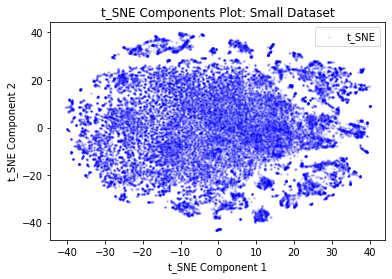

In [13]:
# Plot t_SNE
plot_tsne(tsne_comps_1[:,0], tsne_comps_1[:,1], "Small Dataset")
#plot_tsne(tsne_comps_2[:,0], tsne_comps_2[:,1], "Large Dataset")

![title](img/tsne_time.png)

![title](img/tsne_speed.png)

## 8. t-SNE on small and large dataset: GPU

In [20]:
tsne_1 = cumlTSNE(n_components=2, verbose=1, method='barnes_hut')
tsne_2 = cumlTSNE(n_components=2, verbose=1, method='barnes_hut')

with Timer("tSNE_Small_Dataset"):
    tsne_comps_1 = tsne_1.fit_transform(small_data)


with Timer("tSNE_Large_Dataset"):
    tsne_comps_2 = tsne_2.fit_transform(large_data)

Learning rate is adaptive. In TSNE paper, it has been shown that as n->inf, Barnes Hut works well if n_neighbors->30, learning_rate->20000, early_exaggeration->24.
cuML uses an adpative method.n_neighbors decreases to 30 as n->inf. Likewise for the other params.
New n_neighbors = 50, learning_rate = 14297.333333333332, exaggeration = 24.0
[tSNE_Small_Dataset]
Elapsed: 2.2544713020324707

Learning rate is adaptive. In TSNE paper, it has been shown that as n->inf, Barnes Hut works well if n_neighbors->30, learning_rate->20000, early_exaggeration->24.
cuML uses an adpative method.n_neighbors decreases to 30 as n->inf. Likewise for the other params.
New n_neighbors = 30, learning_rate = 346677.3333333333, exaggeration = 24.0
[tSNE_Large_Dataset]
Elapsed: 53.27359342575073



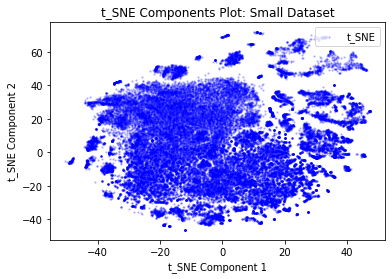

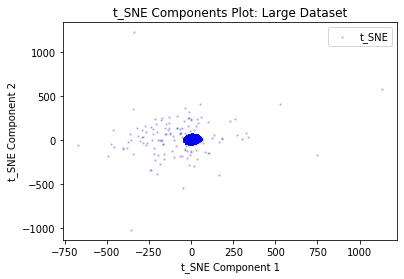

In [21]:
# Plot t_SNE
plot_tsne(tsne_comps_1[:,0], tsne_comps_1[:,1], "Small Dataset")
plot_tsne(tsne_comps_2[:,0], tsne_comps_2[:,1], "Large Dataset")

**Why t_SNE on large dataset is not showing a clear structure?**

[PCA_Large_Dataset]
Elapsed: 12.154080152511597

Learning rate is adaptive. In TSNE paper, it has been shown that as n->inf, Barnes Hut works well if n_neighbors->30, learning_rate->20000, early_exaggeration->24.
cuML uses an adpative method.n_neighbors decreases to 30 as n->inf. Likewise for the other params.
New n_neighbors = 30, learning_rate = 346677.3333333333, exaggeration = 24.0
[tSNE_Large_Dataset]
Elapsed: 46.390822887420654



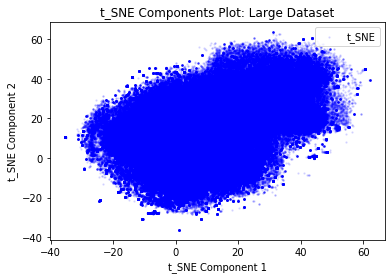

In [30]:
# Try t_SNE on PCA components (first 30 components with highest eigenvalue)

pca_2 = PCA(n_components=30)

with Timer("PCA_Large_Dataset"):
    pr_comps_2 = pca_2.fit_transform(large_data)
    
tsne_2 = cumlTSNE(n_components=2, verbose=1, method='barnes_hut')

with Timer("tSNE_Large_Dataset"):
    tsne_comps_2 = tsne_2.fit_transform(pr_comps_2)

plot_tsne(tsne_comps_2[:,0], tsne_comps_2[:,1], "Large Dataset")

**Check GPU utilization**

In [ ]:
!nvidia-smi

![title](img/nvidia_smi.png)